# Cohort Analysis
### performed by Aris Dressino using notebook within JupyterLab

### 1) import df and perform exploratory analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
df_orders = pd.read_parquet('orders_data.parquet')
df_orders.head()

,billing_address_country,billing_address_zip,customer_id,order_number,total_discounts,cancel_reason,processed_at,total_weight,cancelled_at,created_at,product_items,first_date_order
0,Germany,81371,43539353630,1,0,customer,2019-12-03 13:08:32 UTC,0,2019-12-04 09:00:44 UTC,2019-12-03 13:08:33 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-03 13:08:33 UTC
1,Germany,12045,43973434860,2,0,customer,2019-12-04 09:23:09 UTC,0,2020-01-20 14:55:25 UTC,2019-12-04 09:23:09 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-04 09:23:09 UTC
2,Germany,8315,46668580946,3,0,None,2019-12-06 07:58:34 UTC,0,None,2019-12-06 07:58:34 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-06 07:58:34 UTC
3,Germany,91301,40345377076,4,0,None,2019-12-06 18:29:03 UTC,0,None,2019-12-06 18:29:04 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-06 18:29:04 UTC
4,Germany,8577,33355469588,5,0,None,2019-12-08 18:16:40 UTC,0,None,2019-12-08 18:16:40 UTC,Golf_set_with_caddy_shoes_and_50_balls,2019-12-08 18:16:40 UTC


In [3]:
#not needed for cohort analysis
df_products = pd.read_parquet('products_data.parquet')
df_products.head()

,product_type,product_price,product_category,product_title
0,glove,39.99,golf,Golf_glove_left_hand
1,golf_balls,99.99,golf,Golf_balls_200
2,golf_balls,99.99,golf,Golf_balls_200
3,golf_balls,59.99,golf,Golf_balls_100
4,golf_balls,59.99,golf,Golf_balls_100


In [4]:
#checking for missing values
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189140 entries, 0 to 189139
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   billing_address_country  189138 non-null  object
 1   billing_address_zip      189126 non-null  object
 2   customer_id              189140 non-null  int64 
 3   order_number             189140 non-null  int64 
 4   total_discounts          189140 non-null  int64 
 5   cancel_reason            1586 non-null    object
 6   processed_at             189140 non-null  object
 7   total_weight             189140 non-null  int64 
 8   cancelled_at             1586 non-null    object
 9   created_at               189140 non-null  object
 10  product_items            189140 non-null  object
 11  first_date_order         189140 non-null  object
dtypes: int64(4), object(8)
memory usage: 17.3+ MB


In [5]:
#summary statistics of quantitative variables
df_orders.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
customer_id,189140.0,5.048123e+10,2.562484e+10,774340.0,3.498364e+10,4.644472e+10,6.848076e+10,9.999933e+10
order_number,189140.0,9.440032e+04,5.459239e+04,1.0,4.711875e+04,9.440350e+04,1.416882e+05,1.888100e+05
total_discounts,189140.0,8.854288e-02,8.599538e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
total_weight,189140.0,8.810323e+02,7.824621e+03,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e+06


In [6]:
#looking for percentage of retentions
n_orders = df_orders.groupby(['customer_id'])['order_number'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df_orders['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

16.05% of customers ordered more than once.


/Users/dress/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


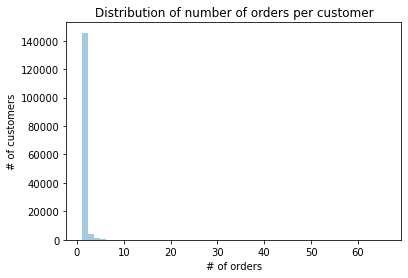

In [7]:
#distribution of number of orders per customer
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

## 2) perform cohort analysis

In [8]:
#select data for cohort analysis and drop duplicate values
df_orders = df_orders[['customer_id', 'order_number', 'created_at', 'first_date_order']].drop_duplicates()
df_orders['created_at'] = pd.to_datetime(df_orders['created_at'])
df_orders['first_date_order'] = pd.to_datetime(df_orders['first_date_order'])
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188863 entries, 0 to 189139
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   customer_id       188863 non-null  int64              
 1   order_number      188863 non-null  int64              
 2   created_at        188863 non-null  datetime64[ns, UTC]
 3   first_date_order  188863 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(2)
memory usage: 7.2 MB


In [9]:
df_orders['order_month'] = df_orders['created_at'].dt.to_period('M') #truncated month of the purchase date
df_orders['cohort'] = df_orders.groupby('customer_id')['first_date_order'] \
                 .transform('min') \
                 .dt.to_period('M')  #monthly cohort based on the first purchase date

/Users/dress/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [10]:
#aggregate the data per cohort and order_month and count the number of unique customers in each group
df_cohort = df_orders.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)

#number of periods between the cohort month and the month of the purchase
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort['period_number']

0      0
1      1
2      2
3      3
4      5
      ..
126    1
127    2
128    0
129    1
130    0
Name: period_number, Length: 131, dtype: int64

In [11]:
#transform dataframe into pivot table
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [12]:
#obtain retention matrix by dividing the values each row by the cohort size
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

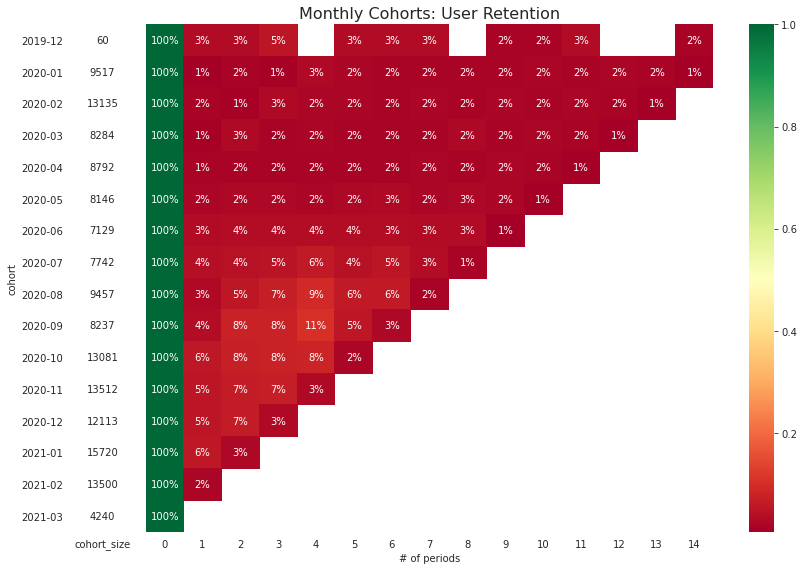

In [13]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

### What are the repurchase rates of the different cohorts?

Actually, we can see that the retention rate is quite low in general, it is well below 10% meaning that not many people are buying the product again after the first purchase.

### What trends do you see in the behaviour over time?

Considering the low retention rate highlited in the previous answer, we can notice that we have a slight increase from 2020-07 to 2020-12, probably due to more incisive marketing campaigns reaching the right customers in the considered time interval.